In [6]:
import os

os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras.utils import Sequence
from keras.layers import Layer, Dense, GlobalAveragePooling1D, Reshape
from keras.initializers import RandomNormal
from keras.models import Sequential
import keras.ops as ops

import numpy as np
import bayesflow as bf
import random

import torch

from losses import logistic_loss, exponential_loss, alpha_log_exponential_loss, cross_entropy_loss, lpop_exponential_loss, alpha_exponential_loss

print(keras.backend.backend())

torch


In [7]:
print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA available: True
GPU device: NVIDIA GeForce RTX 3070


### Simulator and Data Preparation

In [8]:
# create model simulators

def prior_alternative():
    return np.random.normal(loc=0, scale=1)

def sample_model_0(sample_size, n=30):
    samples = np.random.normal(loc=0, scale=1, size=(sample_size, n))
    return samples

def sample_model_1(sample_size, n=30):
    mus = np.array([prior_alternative() for _ in range(sample_size)])

    samples = np.random.normal(loc=mus[:, None], scale=1, size=(sample_size, n))
    return samples

# n generating functions

def variable_n(min=20, max=30):
    return random.randint(min, max)

def constant_n(n=30):
    return n

n_norm_factor = 30

In [9]:
class DataGenerator(Sequence):

    def __init__(self, batches_per_epoch, n_generator, batch_size=32, n_norm=30, **kwargs):
        super().__init__(**kwargs)
        self.batches_per_epoch = batches_per_epoch
        self.batch_size = batch_size
        self.n_gen = n_generator
        self.n_norm = n_norm

    def __len__(self):
        return self.batches_per_epoch

    def __getitem__(self, index):
        sample_n = self.n_gen()

        batch_size_0 = self.batch_size // 2
        batch_size_1 = self.batch_size - batch_size_0

        data_0 = sample_model_0(batch_size_0, n=sample_n)
        data_1 = sample_model_1(batch_size_1, n=sample_n)

        X_batch = np.concatenate([data_0, data_1], axis=0)
        y_batch = np.concatenate([np.zeros(batch_size_0), np.ones(batch_size_1)], axis=0)

        perm = np.random.permutation(len(X_batch))
        X_batch = X_batch[perm]
        y_batch = y_batch[perm]

        n_batch = np.full((self.batch_size, 1), (sample_n/self.n_norm), dtype=np.float32)

        return (X_batch[:, :, None], n_batch), y_batch[:, None]

In [10]:
# dataloader

batch_size = 128
train_batches_per_epoch = 256
val_batches_per_epoch = 8

train_loader = DataGenerator(
    batches_per_epoch=train_batches_per_epoch,
    n_generator=variable_n,
    batch_size=batch_size,
    n_norm=n_norm_factor
)
val_loader = DataGenerator(
    batches_per_epoch=val_batches_per_epoch,
    n_generator=variable_n,
    batch_size=batch_size,
    n_norm=n_norm_factor
)

### Network

In [11]:
class EvidenceNetwork(keras.Model):
    def __init__(self, output, **kwargs):
        super().__init__(**kwargs)

        # shared backbone network
        self.summary_network = bf.networks.DeepSet(summary_dim=8, dropout=None)
        self.classification_network = bf.networks.MLP(widths=[32] * 4, activation="silu", dropout=None)

        # output layer depends on output type
        if output == "p":
            self.output_layer = Dense(1, activation="sigmoid",
                                      kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))  # probability 0-1
        elif output == "K":
            self.output_layer = Dense(1,activation="softplus",
                                      kernel_initializer=RandomNormal(mean=np.log(np.exp(1)-1), stddev=0.01))  # strictly positive
        elif output == "log(K)":
            self.output_layer = Dense(1, activation=None,
                                       kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))  # unbounded
        else:
            raise ValueError("Invalid output type")


    def call(self, inputs, training=False):
        x, n = inputs
        x = self.summary_network(x, training=training)
        x = keras.ops.concatenate([x, n], axis=-1)
        x = self.classification_network(x, training=training)
        return self.output_layer(x)

In [12]:
# custom accuracy

def logk_accuracy(y_true, f_x):
    p = ops.sigmoid(f_x)
    preds = ops.cast(p > 0.5, "float32")
    return ops.mean(ops.cast(ops.equal(preds, ops.cast(y_true, "float32")), "float32"))

def k_accuracy(y_true, y_pred, alpha=2.0):
    y_true = ops.cast(y_true, dtype='float32')
    pred_labels = ops.cast(ops.greater(y_pred, 1), dtype='float32')
    correct = ops.equal(pred_labels, y_true)
    return ops.mean(ops.cast(correct, dtype='float32'), axis=-1)


epochs = 10

learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=epochs * train_batches_per_epoch
)


# create models

classifier_log = EvidenceNetwork("log(K)")
classifier_ce = EvidenceNetwork("p")
classifier_exp = EvidenceNetwork("log(K)")
classifier_alpha_exp = EvidenceNetwork("log(K)")
classifier_alpha_exp_log = EvidenceNetwork("K")
classifier_lpop = EvidenceNetwork("log(K)")

classifier_log.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=logistic_loss, metrics=[logk_accuracy]
)
classifier_ce.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=cross_entropy_loss, metrics=["accuracy"]
)
classifier_exp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=exponential_loss, metrics=[logk_accuracy]
)
classifier_alpha_exp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=alpha_exponential_loss, metrics=[logk_accuracy]
)
classifier_alpha_exp_log.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=alpha_log_exponential_loss, metrics=[k_accuracy]
)
classifier_lpop.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=lpop_exponential_loss, metrics=[logk_accuracy]
)

### Training

In [13]:
with torch.enable_grad():

    print("Logistic")
    history_log = classifier_log.fit(
        train_loader,
        validation_data=val_loader,
        epochs=epochs,
    )
    print()

    print("Cross Entropy")
    history_ce = classifier_ce.fit(
        train_loader,
        validation_data=val_loader,
        epochs=epochs,
    )
    print()

    print("Exponential")
    history_exp = classifier_exp.fit(
        train_loader,
        validation_data=val_loader,
        epochs=epochs,
    )
    print()

    print("Alpha-Exponential")
    history_alpha_exp = classifier_alpha_exp.fit(
        train_loader,
        validation_data=val_loader,
        epochs=epochs,
    )
    print()

    print("Alpha-Log-Exponential")
    history_alpha_exp_log = classifier_alpha_exp_log.fit(
        train_loader,
        validation_data=val_loader,
        epochs=epochs,
    )
    print()

    print("lPOP")
    history_lpop = classifier_lpop.fit(
        train_loader,
        validation_data=val_loader,
        epochs=epochs,
    )
    print()

Logistic
Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - logk_accuracy: 0.7927 - loss: 0.4394 - val_logk_accuracy: 0.8145 - val_loss: 0.3932
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - logk_accuracy: 0.8137 - loss: 0.4083 - val_logk_accuracy: 0.8145 - val_loss: 0.4135
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - logk_accuracy: 0.8230 - loss: 0.3936 - val_logk_accuracy: 0.8369 - val_loss: 0.3826
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - logk_accuracy: 0.8224 - loss: 0.3928 - val_logk_accuracy: 0.8467 - val_loss: 0.3572
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - logk_accuracy: 0.8229 - loss: 0.3917 - val_logk_accuracy: 0.8125 - val_loss: 0.4143
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - logk_accuracy: 0.8242 - loss: 0.3883 - val_logk_accuracy: 0.8398 - val_loss: 0.3738
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - logk_accuracy: 0.8277 - loss: 0.3858 - val_logk_accuracy: 0.8350 - val_loss: 0.3735
Epoch 8/10
256/256

### Testing

In [14]:
def test_model_batch(model, threshold, sample_size=1000, n=30, pr=True):
    # decision thresholds

    num_samples_per_class = sample_size // 2
    data_0 = sample_model_0(num_samples_per_class, n=n)
    data_1 = sample_model_1(num_samples_per_class, n=n)

    X_test = np.concatenate([data_0, data_1], axis=0)
    X_test = X_test[:, :, None]

    n_test = np.full((sample_size, 1), (n/n_norm_factor), dtype=np.float32)

    labels_0 = np.zeros((num_samples_per_class, 1))
    labels_1 = np.ones((num_samples_per_class, 1))
    y_true = np.concatenate([labels_0, labels_1], axis=0)

    y_pred = model((X_test, n_test), training=False)

    if isinstance(y_pred, tuple):
        y_pred = y_pred[0]

    pred_labels = ops.cast(y_pred > threshold, "float32")
    y_true_tensor = ops.convert_to_tensor(y_true, dtype="float32")

    is_class_0 = ops.equal(y_true_tensor, 0.0)
    is_class_1 = ops.equal(y_true_tensor, 1.0)

    correct_preds = ops.equal(pred_labels, y_true_tensor)

    correct_0 = ops.sum(ops.cast(ops.logical_and(correct_preds, is_class_0), "float32"))
    correct_1 = ops.sum(ops.cast(ops.logical_and(correct_preds, is_class_1), "float32"))

    acc_0 = correct_0 / num_samples_per_class
    acc_1 = correct_1 / num_samples_per_class

    correct_0_np = int(ops.convert_to_numpy(correct_0))
    correct_1_np = int(ops.convert_to_numpy(correct_1))
    acc_0_np = ops.convert_to_numpy(acc_0)
    acc_1_np = ops.convert_to_numpy(acc_1)

    if pr:
        print(f"Model 0 accuracy: {acc_0_np*100:.2f}% ({correct_0_np}/{num_samples_per_class})")
        print(f"Model 1 accuracy: {acc_1_np*100:.2f}% ({correct_1_np}/{num_samples_per_class})")

    return acc_0_np, acc_1_np

In [15]:
n = 25

print("n = 25: ")
print()

print("Logistic")
test_model_batch(classifier_log, threshold=0, sample_size=1000, n=n)
print()

print("Cross Entropy")
test_model_batch(classifier_ce, threshold=0.5, sample_size=1000, n=n)
print()

print("Exponential")
test_model_batch(classifier_exp, threshold=0, sample_size=1000, n=n)
print()

print("Alpha Exponential")
test_model_batch(classifier_alpha_exp, threshold=0, sample_size=1000, n=n)
print()

print("Alpha Exponential Log")
test_model_batch(classifier_alpha_exp_log, threshold=1, sample_size=1000, n=n)
print()

print("l-POP")
test_model_batch(classifier_lpop, threshold=0, sample_size=1000, n=n)
print()

print()

n = 10 # M0: 89%  M1: 62% on bf tutorial

print("n = 10: ")
print()

print("Logistic")
test_model_batch(classifier_log, threshold=0, sample_size=1000, n=n)
print()

print("Cross Entropy")
test_model_batch(classifier_ce, threshold=0.5, sample_size=1000, n=n)
print()

print("Exponential")
test_model_batch(classifier_exp, threshold=0, sample_size=1000, n=n)
print()

print("Alpha Exponential")
test_model_batch(classifier_alpha_exp, threshold=0, sample_size=1000, n=n)
print()

print("Alpha Exponential Log")
test_model_batch(classifier_alpha_exp_log, threshold=1, sample_size=1000, n=n)
print()

print("l-POP")
test_model_batch(classifier_lpop, threshold=0, sample_size=1000, n=n)
print()

n = 25: 

Logistic
Model 0 accuracy: 94.40% (472/500)
Model 1 accuracy: 72.60% (363/500)

Cross Entropy
Model 0 accuracy: 93.20% (466/500)
Model 1 accuracy: 71.40% (357/500)

Exponential
Model 0 accuracy: 94.60% (473/500)
Model 1 accuracy: 69.00% (345/500)

Alpha Exponential
Model 0 accuracy: 93.00% (465/500)
Model 1 accuracy: 66.20% (331/500)

Alpha Exponential Log
Model 0 accuracy: 92.40% (462/500)
Model 1 accuracy: 72.40% (362/500)

l-POP
Model 0 accuracy: 93.00% (465/500)
Model 1 accuracy: 69.60% (348/500)


n = 10: 

Logistic
Model 0 accuracy: 75.20% (376/500)
Model 1 accuracy: 74.00% (370/500)

Cross Entropy
Model 0 accuracy: 74.00% (370/500)
Model 1 accuracy: 68.60% (343/500)

Exponential
Model 0 accuracy: 75.20% (376/500)
Model 1 accuracy: 71.00% (355/500)

Alpha Exponential
Model 0 accuracy: 74.40% (372/500)
Model 1 accuracy: 74.20% (371/500)

Alpha Exponential Log
Model 0 accuracy: 85.40% (427/500)
Model 1 accuracy: 66.60% (333/500)

l-POP
Model 0 accuracy: 76.20% (381/500)
M

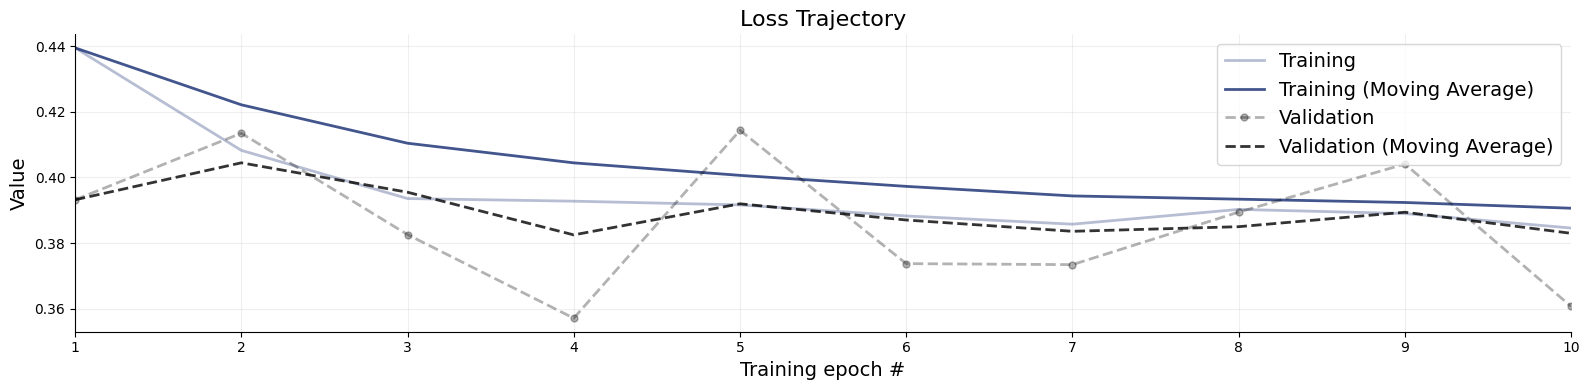

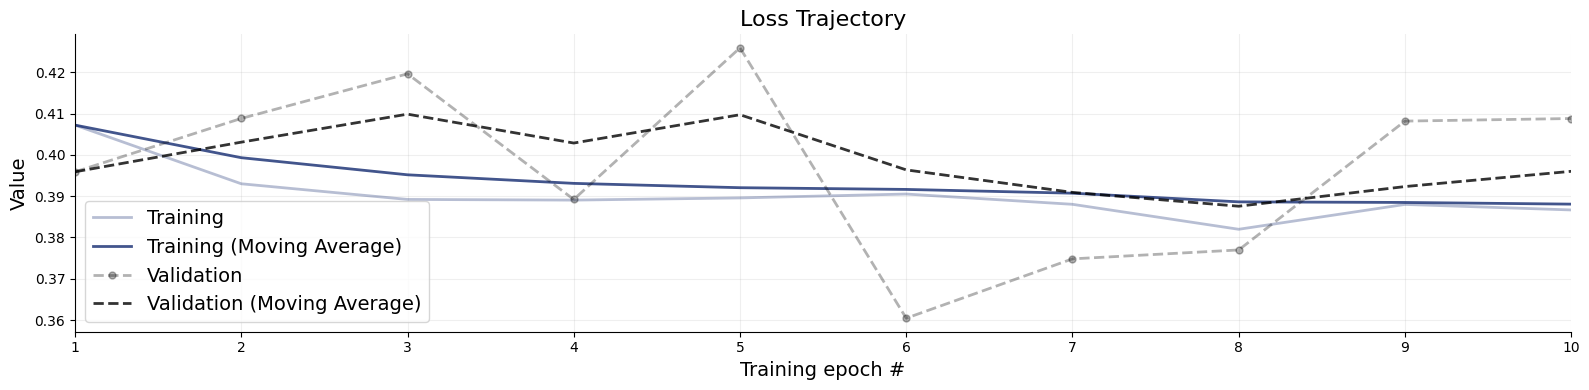

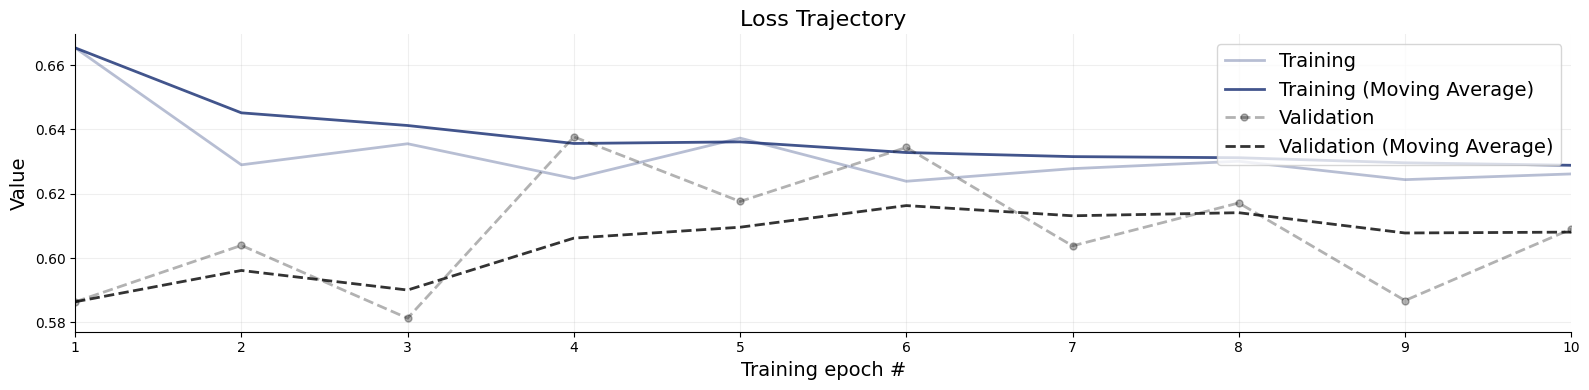

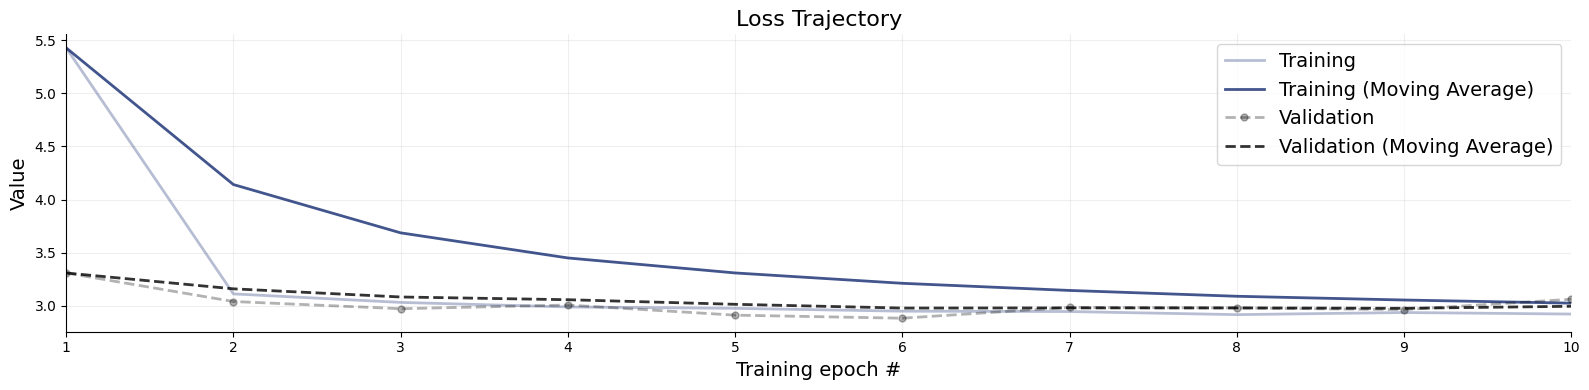

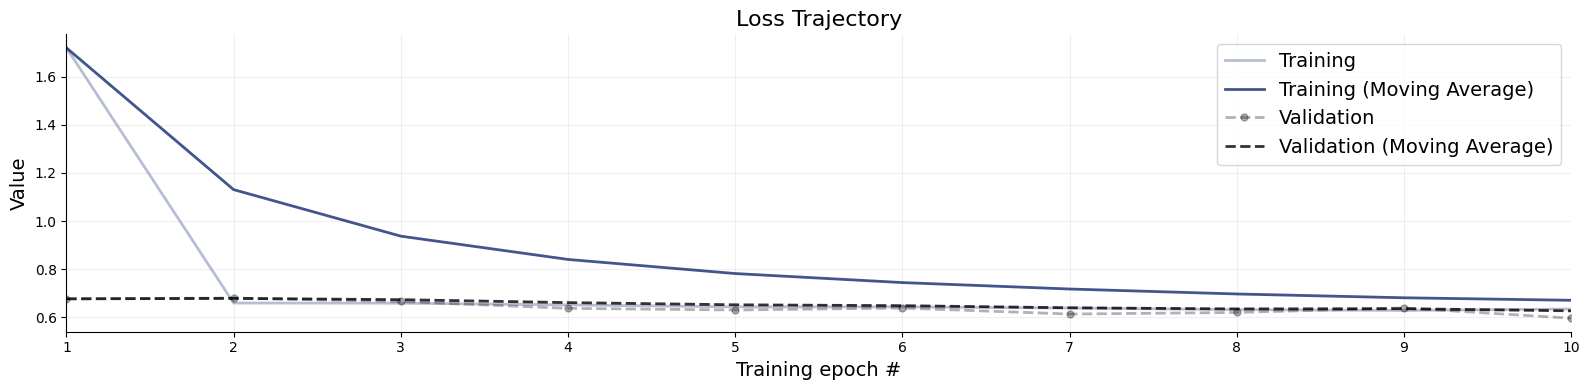

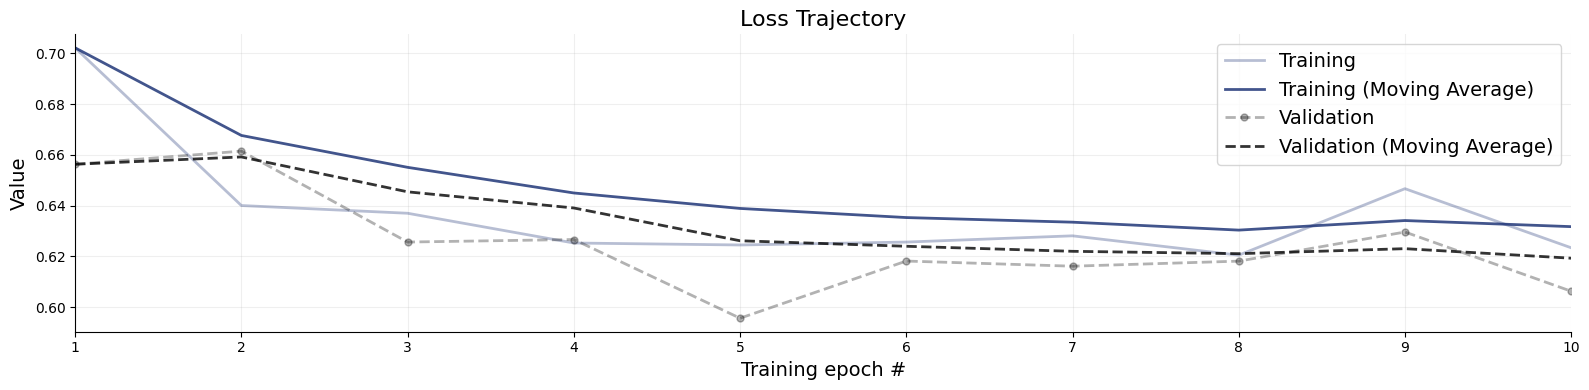

In [16]:
f_log = bf.diagnostics.plots.loss(history=history_log)

f_ce = bf.diagnostics.plots.loss(history=history_ce)

f_exp = bf.diagnostics.plots.loss(history=history_exp)

f_alpha_exp = bf.diagnostics.plots.loss(history=history_alpha_exp)

f_alpha_exp_log = bf.diagnostics.plots.loss(history=history_alpha_exp_log)

f_lpop = bf.diagnostics.plots.loss(history=history_lpop)